<a href="https://colab.research.google.com/github/Nahom32/Environmental-Map-Segmentation/blob/main/notebooks/mrf_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage.color import rgb2lab

# Task 2


In [ ]:
import requests

# Coordinates of the location
lat, lon = 37.42476, 11.57628

# Example using Open-Elevation API
response = requests.get(f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}")
elevation = response.json()['results'][0]['elevation']
print(f"Elevation at ({lat}, {lon}): {elevation} meters")

Elevation at (37.42476, 11.57628): 0.0 meters


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 3

In [ ]:
img_path = "/content/drive/MyDrive/sentinel_rgb.tif"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, (350, 350))
img_lab = rgb2lab(img_rgb)

In [ ]:
from skimage.segmentation import random_walker
from skimage import img_as_float
from skimage.filters import gaussian

In [ ]:
img_smooth = gaussian(img_lab[:, :, 1], sigma=1)  # use 'a*' channel for greenness

# Initialize markers (0 = unlabeled, 1 = background, 2 = green)
markers = np.zeros(img_smooth.shape, dtype=np.uint)
markers[img_smooth > 10] = 1      # red/yellow shades as background
markers[img_smooth < -5] = 2      # green-ish areas


In [ ]:
labels = random_walker(img_smooth, markers, beta=10, mode='bf')


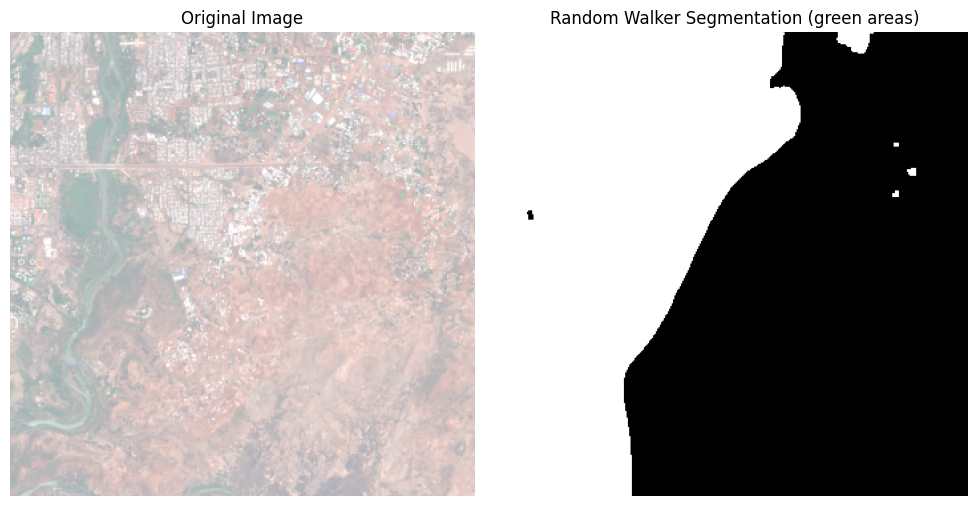

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(labels, cmap='gray')
plt.title("Random Walker Segmentation (green areas)")
plt.axis('off')

plt.tight_layout()
plt.show()

### Task 4

In [ ]:
h, w = labels.shape
center = np.array([175, 175])  # pixel center of image

# Create blank overlay
overlay = img_rgb.copy()

# 1. Find contours of vegetation (label == 2)
veg_mask = (labels == 2).astype(np.uint8)
contours, _ = cv2.findContours(veg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
for cnt in contours:
    # Find center of the vegetation cluster
    M = cv2.moments(cnt)
    if M["m00"] == 0:
        continue
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    cluster_center = np.array([cx, cy])

    # Draw line (edge) from building to vegetation cluster
    cv2.line(overlay, tuple(center), (cx, cy), (0, 255, 0), 1)  # green line

    # Compute distance
    dist = np.linalg.norm(cluster_center - center)
    ft_per_px = 1000 / 333  # ≈ 3 ft/px

    if dist * ft_per_px <= 200:
        color = (255, 0, 0)  # Blue
    elif dist * ft_per_px <= 1000:
        color = (0, 0, 255)  # Red
    else:
        continue  # skip beyond 1000 ft

    # Draw boundary around cluster (circle)
    cv2.circle(overlay, (cx, cy), 10, color, 2)

array([[[199, 194, 192],
        [204, 196, 195],
        [204, 196, 194],
        ...,
        [179, 183, 188],
        [212, 205, 210],
        [246, 234, 237]],

       [[198, 193, 194],
        [206, 198, 197],
        [204, 195, 194],
        ...,
        [181, 185, 190],
        [223, 230, 221],
        [248, 232, 238]],

       [[189, 191, 191],
        [210, 199, 198],
        [199, 194, 193],
        ...,
        [190, 186, 189],
        [205, 196, 197],
        [208, 202, 198]],

       ...,

       [[210, 193, 193],
        [204, 191, 191],
        [202, 189, 191],
        ...,
        [227, 208, 202],
        [225, 207, 202],
        [233, 211, 207]],

       [[197, 188, 190],
        [200, 189, 190],
        [187, 185, 187],
        ...,
        [230, 211, 205],
        [232, 211, 206],
        [242, 216, 210]],

       [[199, 189, 191],
        [195, 186, 189],
        [196, 185, 189],
        ...,
        [232, 210, 204],
        [232, 210, 205],
        [246, 220, 213]]], dtype=uint8)
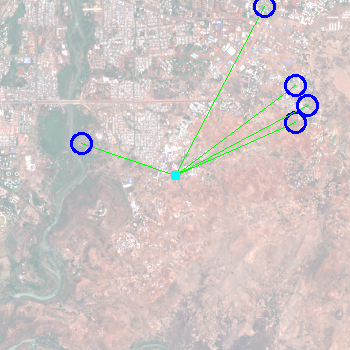

In [ ]:
cv2.circle(overlay, tuple(center), 5, (0, 255, 255), -1)

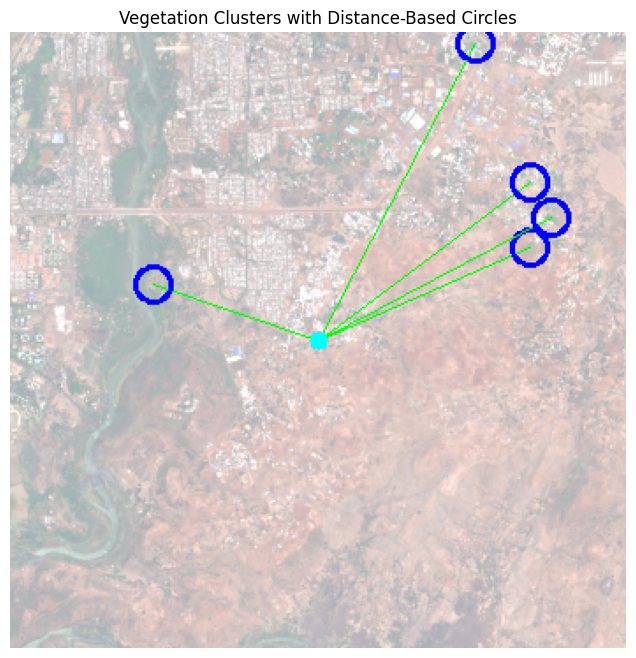

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(overlay)
plt.title("Vegetation Clusters with Distance-Based Circles")
plt.axis("off")
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def evaluate_segmentation(pred_mask, gt_mask):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    acc = accuracy_score(gt_flat, pred_flat)
    prec = precision_score(gt_flat, pred_flat, zero_division=0)
    rec = recall_score(gt_flat, pred_flat, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, zero_division=0)
    iou = jaccard_score(gt_flat, pred_flat, zero_division=0)

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"IoU (Jaccard): {iou:.4f}")

In [27]:

lab_img = rgb2lab(img_rgb)
a_channel = lab_img[:, :, 1]


gt_mask = (a_channel < -5).astype(np.uint8)


pred_mask = (labels == 2).astype(np.uint8)

# Evaluate
evaluate_segmentation(pred_mask, gt_mask)

Accuracy     : 0.6064
Precision    : 0.0853
Recall       : 0.9347
F1 Score     : 0.1563
IoU (Jaccard): 0.0848
